In [1]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.gamma_ray_parameters import energy_res_comptel, energy_res_fermi
from hazma.pseudo_scalar_mediator import PseudoScalarMFV, PseudoScalarMediator

from utilities import get_color, get_tex_label, latex_text_width_1col

## Type III 2HDM ($g_{Pu} = -g_{Pd}$, $g_{P\ell} = 0$)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

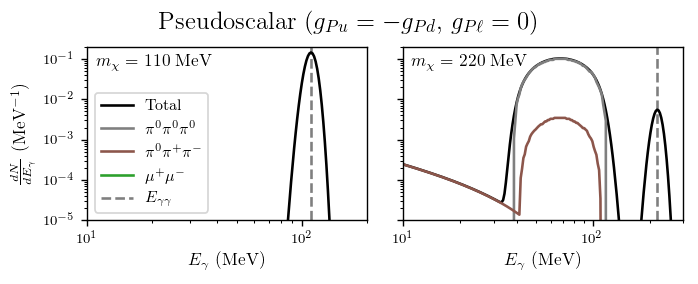

In [5]:
# Type II 2HDM couplings
gpuu = 1.
gpdd = -1.
gpll = 0.

psm = PseudoScalarMFV(mx=220., mp=1e3, gpxx=1., gpup=gpuu, gpdown=gpdd,
                      gpll=gpll)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion
###
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

n_subplot_rows, n_subplot_cols = 1, 2
mxs = np.array([110., 220.]).reshape((n_subplot_rows, n_subplot_cols))
###
plt.figure(figsize=(latex_text_width_1col, 0.4*latex_text_width_1col))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    psm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*psm.mx * (1. + 0.5 * vx_mw**2)

    # Plot total convolved spectrum
    dnde_det = psm.get_detected_spectrum(e_gam_min, e_gam_max,
                                        e_cm, energy_res=energy_res_comptel)
    plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
    
    # Plot individual channels' spectra
    for fs, spec in reversed(sorted(psm.spectra(e_gams, e_cm).iteritems())):
        if fs not in ["total", "p p", "g g", "e e"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs),
                       color=get_color(fs),
                       linewidth=1.5)

    # Mark the lines' energies
    for ch, line in psm.gamma_ray_lines(e_cm).iteritems():
        plt.axvline(line["energy"], linestyle='--', color="k", alpha=0.5,
                    linewidth=1.5, label=r"$E_{\gamma\gamma}$")

    ### Formatting
    # Set axis limits
    if idx == 0:
        plt.xlim(10, 200)
    else:
        plt.xlim(10, 300)
        
    plt.ylim(1e-5, 2e-1)

    # Only draw the legend for the first subplot
    if idx == 0:
        plt.legend(loc="lower left")
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(1.1e1, 6e-2, r"$m_\chi = %0.f$ MeV" % psm.mx,
             fontsize=10)
    
    it.iternext()

plt.suptitle(r"Pseudoscalar ($g_{Pu} = -g_{Pd}$, $g_{P\ell} = 0$)")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # remove some of the space between plots
# plt.savefig("figures/pseudoscalar_spectra_type_III_2HDM.pdf")

## Type II 2HDM ($g_{Pu} \neq 0$, $g_{Pd} = g_{P\ell} = 0$)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

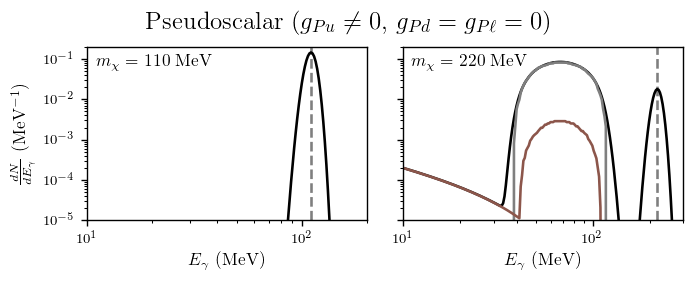

In [9]:
# Type II 2HDM couplings
gpuu = 1.
gpdd = 0.
gpll = 0.

psm = PseudoScalarMFV(mx=220., mp=1e3, gpxx=1.,
                      gpup=gpuu, gpdown=gpdd, gpll=gpll)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion
###
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

n_subplot_rows, n_subplot_cols = 1, 2
mxs = np.array([110., 220.]).reshape((n_subplot_rows, n_subplot_cols))
###
plt.figure(figsize=(latex_text_width_1col, 0.4*latex_text_width_1col))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    psm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*psm.mx * (1. + 0.5 * vx_mw**2)

    # Plot total convolved spectrum
    dnde_det = psm.get_detected_spectrum(e_gam_min, e_gam_max,
                                        e_cm, energy_res=energy_res_comptel)
    plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
    
    # Plot individual channels' spectra
    for fs, spec in reversed(sorted(psm.spectra(e_gams, e_cm).iteritems())):
        if fs not in ["total", "p p", "g g"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs),
                       color=get_color(fs),
                       linewidth=1.5)

    # Mark the lines' energies
    for ch, line in psm.gamma_ray_lines(e_cm).iteritems():
        plt.axvline(line["energy"], linestyle='--', color="k", alpha=0.5,
                    linewidth=1.5, label=r"$E_{\gamma\gamma}$")

    ### Formatting
    # Set axis limits
    if idx == 0:
        plt.xlim(10, 200)
    else:
        plt.xlim(10, 300)
        
    plt.ylim(1e-5, 2e-1)
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(1.1e1, 6e-2, r"$m_\chi = %0.f$ MeV" % psm.mx,
             fontsize=10)
    
    it.iternext()

plt.suptitle(r"Pseudoscalar ($g_{Pu} \neq 0$, $g_{Pd} = g_{P\ell} = 0$)")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # remove some of the space between plots
plt.savefig("figures/pseudoscalar_spectra_type_II_2HDM_gpd_gpl_0.pdf")

## Type II 2HDM ($g_{Pu} = 0$, $g_{Pd} = -g_{P\ell}$)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

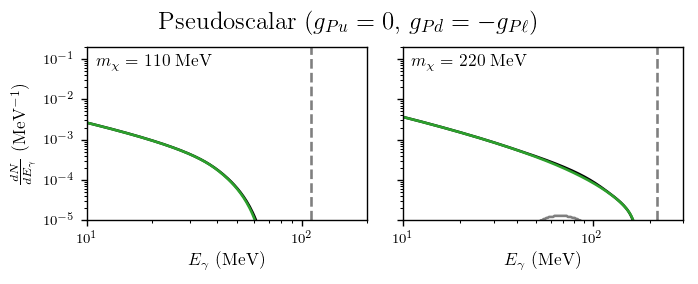

In [4]:
# Type II 2HDM couplings
gpuu = 0.
gpdd = -1.
gpll = 1.

psm = PseudoScalarMFV(mx=220., mp=1e3, gpxx=1.,
                      gpup=gpuu, gpdown=gpdd, gpll=gpll)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion
###
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

n_subplot_rows, n_subplot_cols = 1, 2
mxs = np.array([110., 220.]).reshape((n_subplot_rows, n_subplot_cols))
###
plt.figure(figsize=(latex_text_width_1col, 0.4*latex_text_width_1col))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    psm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*psm.mx * (1. + 0.5 * vx_mw**2)

    # Plot total convolved spectrum
    dnde_det = psm.get_detected_spectrum(e_gam_min, e_gam_max,
                                        e_cm, energy_res=energy_res_comptel)
    plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
    
    # Plot individual channels' spectra
    for fs, spec in reversed(sorted(psm.spectra(e_gams, e_cm).iteritems())):
        if fs not in ["total", "p p", "g g", "pi0 pi pi"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs),
                       color=get_color(fs),
                       linewidth=1.5)

    # Mark the lines' energies
    for ch, line in psm.gamma_ray_lines(e_cm).iteritems():
        plt.axvline(line["energy"], linestyle='--', color="k", alpha=0.5,
                    linewidth=1.5, label=r"$E_{\gamma\gamma}$")

    ### Formatting
    # Set axis limits
    if idx == 0:
        plt.xlim(10, 200)
    else:
        plt.xlim(10, 300)
        
    plt.ylim(1e-5, 2e-1)
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(1.1e1, 6e-2, r"$m_\chi = %0.f$ MeV" % psm.mx,
             fontsize=10)
    
    it.iternext()

plt.suptitle(r"Pseudoscalar ($g_{Pu} = 0$, $g_{Pd} = -g_{P\ell}$)")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # remove some of the space between plots
plt.savefig("figures/pseudoscalar_spectra_type_II_2HDM_gpu_0.pdf")

## Coupling dependence
Need to make this plot prettier.

In [2]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [11]:
# Type II 2HDM couplings
gpuu = 1.
gpdd = 0.
gpll = 0.

psm = PseudoScalarMFV(mx=220., mp=1e3, gpxx=1.,
                      gpup=gpuu, gpdown=gpdd, gpll=gpll)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

In [12]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

In [31]:
# Coupling ratios
ratios = np.linspace(-5, 5, 10)

In [32]:
# Set up the colormap
cmap = cm.viridis_r
norm = Normalize(vmin=ratios[0], vmax=ratios[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(ratios)

In [33]:
# Compute the spectra!
spectra_det = {}

# Center of mass energy, set to slightly above threshold
e_cm = 2.*psm.mx * (1. + 0.5 * vx_mw)

for ratio in ratios:
    psm.gpdown = ratio * psm.gpup

    spec = psm.spectra(e_gams, e_cm)["total"]

    dnde_det = psm.get_detected_spectrum(e_gam_min, e_gam_max,
                                        e_cm, energy_res=energy_res_comptel)

    spectra_det[ratio] = dnde_det(e_gams)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

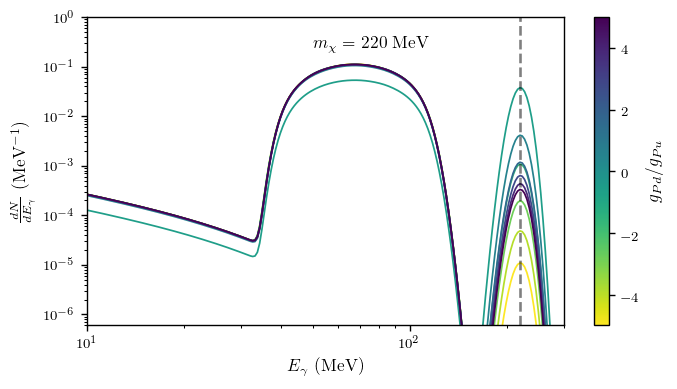

In [34]:
plt.figure(figsize=(latex_text_width_1col, 0.6*latex_text_width_1col))

# Only plot one curve if they all overlap
for ratio in ratios:
    plt.loglog(e_gams, spectra_det[ratio],
              color=m.to_rgba(ratio), linewidth=1)

# Mark the lines' energies
for ch, line in psm.gamma_ray_lines(e_cm).iteritems():
    plt.axvline(line["energy"], linestyle='--', color="k", alpha=0.5,
                linewidth=1.5, label=r"$E_{\gamma\gamma}$")

# Formatting
plt.xlim(10, 300)
plt.ylim(6e-7, 1e0)
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
# Label subplot with dark matter mass
plt.text(5e1, 2.18e-1, r"$m_\chi = %0.f$ MeV" % psm.mx,
        fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # remove some of the space between plots
# plt.suptitle(r"Vector mediator")

plt.colorbar(m).set_label(r"$g_{Pd} / g_{Pu}$")

# plt.savefig("figures/vector_spectra_coupling_dependence.pdf")